In [69]:
import os
import glob
import random
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [70]:
SEED = 42

# Python, NumPy, PyTorch 모두 동일하게 고정
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # multi-GPU일 경우

# CuDNN 연산에서 완전 재현성 보장
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def load_clean_csv(path):
    with open(path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

    header_idx = None
    for i, line in enumerate(lines):
        if "날짜 시간" in line:
            header_idx = i
            break

    if header_idx is None:
        raise ValueError(f"'날짜 시간' 행을 찾을 수 없습니다: {path}")

    df = pd.read_csv(path, skiprows=header_idx)
    df['날짜 시간'] = pd.to_datetime(df['날짜 시간'])
    df['날짜'] = df['날짜 시간'].dt.date

    # ---- 클로로필 관련 열 자동 탐색 ----
    chl_cols = [c for c in df.columns if "Chlorophyll" in c and "농도" in c]

    for col in chl_cols:
        if "(ppb)" in col:
            # ppb → µg/L 변환
            df[col.replace("(ppb)", "(µg/L)")] = df[col]
            df.drop(columns=[col], inplace=True)
            
    return df

In [4]:
def summarize_point_folder(point_folder, save_dir):
    """하나의 포인트 폴더 내 모든 날짜 CSV를 불러와 평균 요약"""
    summary_list = []

    for date_folder in sorted(os.listdir(point_folder)):
        date_path = os.path.join(point_folder, date_folder)
        if not os.path.isdir(date_path):
            continue  # 혹시 폴더 아닌게 섞여 있을 수도 있음

        daily_dfs = []

        for file in os.listdir(date_path):
            if not file.endswith(".csv"):
                continue
            file_path = os.path.join(date_path, file)
            try:
                df = load_clean_csv(file_path)
                daily_dfs.append(df)
            except Exception as e:
                print(f"⚠️ {file_path} 로드 실패: {e}")

        if len(daily_dfs) == 0:
            continue

        # 여러 CSV를 concat 후 평균 계산
        daily_df = pd.concat(daily_dfs)
        daily_mean = daily_df.mean(numeric_only=True)
        daily_mean["날짜"] = pd.to_datetime(date_folder, format="%Y%m%d").date()

        summary_list.append(daily_mean)

    # 날짜별 평균이 담긴 DataFrame 생성
    if len(summary_list) > 0:
        summary_df = pd.DataFrame(summary_list)
        summary_df.sort_values("날짜", inplace=True)
        cols = ["날짜"] + [c for c in summary_df.columns if c != "날짜"]
        summary_df = summary_df[cols]
        
        point_name = os.path.basename(point_folder.rstrip("/\\"))
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{point_name}_summary.csv")
        summary_df.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"✅ {point_name} 요약 CSV 저장 완료 → {save_path}")
    else:
        print(f"❌ {point_folder} 요약 데이터 없음.")


In [ ]:
# data_dir = "point_data"
# dataset = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)
# print(len(dataset))
# print(dataset[0])

490
point_data\포인트1\20250402\VuSitu_라이브_리딩_2025-04-02_11-07-40_장치_위치.csv


In [ ]:
# sample_path = dataset[0]
# df = load_clean_csv(sample_path)

# print("파일 경로:", sample_path)
# print("데이터 shape:", df.shape)
# print("컬럼명:", df.columns.tolist())
# # print(df.head())

파일 경로: point_data\포인트1\20250402\VuSitu_라이브_리딩_2025-04-02_11-07-40_장치_위치.csv
데이터 shape: (69, 26)
컬럼명: ['날짜 시간', 'Actual Conductivity (µS/cm) (1066342)', 'Specific Conductivity (µS/cm) (1066342)', '염도 (PSU) (1066342)', '저항력 (Ω⋅cm) (1066342)', '밀도 (g/cm³) (1066342)', '총 용존 고형물 (TDS) (ppt) (1066342)', 'pH (pH) (1057024)', 'pH mV (mV) (1057024)', 'ORP (mV) (1057024)', '온도 (°C) (1068851)', '압력 (psi) (1064654)', '깊이 (m) (1064654)', '표면 고도 (m) (1064654)', 'RDO 농도 (mg/L) (954526)', 'RDO 포화 (%Sat) (954526)', '산소분압 (Torr) (954526)', 'Chlorophyll-a Fluorescence (RFU) (945787)', 'Chlorophyll-a 농도 (µg/L) (945787)', '외부 전압 (V) (1068851)', '대기압 (mbar) (1049665)', '온도 (°C) (1049665)', '위도 (°)', '경도 (°)', '표시됨', '날짜']


In [ ]:
# data_num = len(dataset)
# train_dataset, val_dataset, test_dataset = dataset[:int(data_num*0.8)], dataset[int(data_num*0.8):int(data_num*0.9)], dataset[int(data_num*0.9):]
# print(len(train_dataset), len(val_dataset), len(test_dataset))

392 49 49


In [195]:
# def make_sequences(df_point, input_days=7):
#     X, y = [], []
#     for i in range(len(df_point) - input_days):
#         X.append(df_point.iloc[i:i+input_days].values)
#         y.append(df_point.iloc[i+input_days]["chlorophyll"])  # 다음날 예측
#     return np.array(X), np.array(y)

In [71]:
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        input_size: 입력 feature 수
        hidden_size: LSTM hidden 차원
        num_layers: LSTM 층 수
        output_size: 예측값 차원
        """
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: [batch_size, seq_len, input_size]
        """
        out, _ = self.lstm(x)       # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]          # 마지막 시점 출력
        out = self.fc(out)           # [batch, output_size]
        return out

In [72]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
# dataset_root = "point_data"      # 포인트 폴더들이 들어 있는 상위 폴더
# output_dir = "summaries"      # 요약본 저장 폴더
# os.makedirs(output_dir, exist_ok=True)

# for point_folder in sorted(os.listdir(dataset_root)):
#     full_path = os.path.join(dataset_root, point_folder)
#     if os.path.isdir(full_path):
#         summarize_point_folder(full_path, output_dir)

In [ ]:
for i in range(1, 6):
    csv_path = "etc"
    csv_name = f"포인트{i}_통합_6_8_10_선택속성_기상병합.csv"
    df = pd.read_csv(f"{csv_path}/{csv_name}")

    # '날짜 시간' 열에서 날짜만 추출 (시간 제거)
    df["날짜"] = pd.to_datetime(df["날짜 시간"]).dt.date

    # 1️⃣ 같은 날짜 평균내기
    df_avg = df.groupby("날짜").mean(numeric_only=True).reset_index()

    # 2️⃣ 같은 날짜 첫 번째 행만 남기기
    df_first = df.groupby("날짜").first().reset_index()

    # CSV 저장
    df_avg.to_csv(f"data/avg_{csv_name}", index=False, encoding='utf-8-sig')
    df_first.to_csv(f"data/fst_{csv_name}", index=False, encoding='utf-8-sig')

print("Done")

Done


In [156]:
file_path = "data"
file_name = "avg_포인트5_통합_6_8_10_기상병합"
df = pd.read_csv(f"{file_path}/{file_name}.csv")

# 날짜 제거 (index로 쓰거나 feature에서 제외)
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.sort_values('날짜')
try:
    features = df.drop(columns=['날짜', '날짜 시간', 'TM']).values
except:
    features = df.drop(columns=['날짜', 'TM']).values
print("Features shape:", features.shape)
print("First 3 rows:\n", features[:3])

Features shape: (37, 33)
First 3 rows:
 [[ 1.08115756e+00  1.32421356e+00  0.00000000e+00  9.24820547e+05
   9.99013971e-01  8.61702311e-04  7.68056905e+00 -2.91202475e+01
   2.09805642e+02  1.54828678e+01  4.04188804e+00  3.02115148e+00
   2.62606594e+00  4.15292953e+00  4.20107039e+01  5.64296658e+01
   3.77330846e+00  3.78182527e+01  1.72514148e+01  1.00403387e+03
   2.43077556e+01  3.66870522e+01  1.28810018e+02 -9.00000000e+00
  -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 -9.00000000e+00
  -9.00000000e+00 -9.00000000e+00  3.36000000e+00  0.00000000e+00
   2.10000000e+00]
 [ 6.28081300e-01  7.03720964e-01  0.00000000e+00  1.59681250e+06
   9.98283285e-01  4.57549663e-04  7.72501264e+00 -3.17157572e+01
   2.05525212e+02  1.94566999e+01  4.22365355e+00  3.16937243e+00
   2.76389565e+00  3.71359135e+00  4.08545698e+01  5.44102581e+01
   3.66962881e+00  3.67379120e+01  1.72616016e+01  1.00086433e+03
   2.86247821e+01  3.66868450e+01  1.28810107e+02 -9.00000000e+00
  -9.00000000e+00

In [157]:
# 정규화
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Chlorophyll-a 농도 컬럼 인덱스 (features 기준)
chl_flu_idx = 16
chl_nong_idx = 17

seq_len = 5
X, y = [], []
for i in range(len(scaled_features) - seq_len):
    X.append(scaled_features[i:i+seq_len])
    next_day = scaled_features[i + seq_len]
    y.append(next_day[[chl_flu_idx, chl_nong_idx]])  # 두 값 예측

X, y = np.array(X), np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)

train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")
print(X_train[0], y_train[0])

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=8, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=8, shuffle=False)
print(f"train_loader batches: {len(train_loader)}, val_loader batches: {len(val_loader)}, test_loader batches: {len(test_loader)}")

X shape: (32, 5, 33) y shape: (32, 2)
Train size: 25, Val size: 3, Test size: 4
[[6.08411662e-03 8.37868706e-03 0.00000000e+00 5.05081269e-02
  1.00000000e+00 8.39070850e-03 3.93399418e-01 5.03554331e-01
  1.00000000e+00 0.00000000e+00 4.99152471e-01 4.98014254e-01
  5.02915713e-01 3.33515624e-01 2.40278920e-01 2.45056784e-01
  4.14618018e-02 3.05195152e-01 4.73344661e-01 1.00000000e+00
  7.68482238e-02 4.40240475e-01 5.76216925e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.32692308e-01 0.00000000e+00
  3.93939394e-01]
 [3.53447084e-03 4.45264866e-03 0.00000000e+00 8.74426725e-02
  8.69372992e-01 4.45532732e-03 4.03274175e-01 4.94010393e-01
  9.92393077e-01 1.87104533e-01 5.66736651e-01 5.74584329e-01
  5.74774735e-01 2.98233026e-01 2.33666447e-01 2.36355470e-01
  4.03166863e-02 2.96431928e-01 7.23517684e-01 8.29301909e-01
  2.13668876e-01 3.58784947e-01 6.50361823e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.

In [158]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 2
model = VanillaLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [159]:
num_epochs = 300
best_train_loss = float('inf')
best_val_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            preds = model(X_val)
            val_loss += criterion(preds, y_val).item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")\
    
    if val_loss < best_val_loss:
        best_train_loss = total_loss/len(train_loader)
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1

model.load_state_dict(best_model_state)
print(f"✅ {best_epoch} model loaded with Val Loss: {best_val_loss:.6f}")

time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
weight_dir = "weights"
weight_name = f"{time_str}_{file_name}_{best_epoch}epoch.pth"
torch.save(model.state_dict(), f"{weight_dir}/{weight_name}")
print(f"Saved: {weight_dir}/{weight_name}")

Epoch [1/300] Train Loss: 0.149972 | Val Loss: 0.001969
Epoch [2/300] Train Loss: 0.247774 | Val Loss: 0.001192
Epoch [3/300] Train Loss: 0.114483 | Val Loss: 0.006588
Epoch [4/300] Train Loss: 0.234576 | Val Loss: 0.014932
Epoch [5/300] Train Loss: 0.110236 | Val Loss: 0.030937
Epoch [6/300] Train Loss: 0.114198 | Val Loss: 0.033094
Epoch [7/300] Train Loss: 0.192500 | Val Loss: 0.027597
Epoch [8/300] Train Loss: 0.178898 | Val Loss: 0.032650
Epoch [9/300] Train Loss: 0.114582 | Val Loss: 0.038629
Epoch [10/300] Train Loss: 0.152084 | Val Loss: 0.026840
Epoch [11/300] Train Loss: 0.074714 | Val Loss: 0.022508
Epoch [12/300] Train Loss: 0.069387 | Val Loss: 0.012655
Epoch [13/300] Train Loss: 0.050083 | Val Loss: 0.007026
Epoch [14/300] Train Loss: 0.045028 | Val Loss: 0.009018
Epoch [15/300] Train Loss: 0.033011 | Val Loss: 0.010544
Epoch [16/300] Train Loss: 0.034490 | Val Loss: 0.011250
Epoch [17/300] Train Loss: 0.042901 | Val Loss: 0.013647
Epoch [18/300] Train Loss: 0.014543 | Va

MSE per feature → Chl_flu: 0.000473, Chl_nong: 0.019676

=== 마지막 입력 및 예측 결과 ===
입력 시퀀스 (마지막 샘플):
[[3.09198338e-04 2.84151523e-04 0.00000000e+00 1.00000000e+00
  0.00000000e+00 2.84343143e-04 7.01317012e-01 2.93710083e-01
  6.09872878e-01 1.00000000e+00 8.44624341e-02 8.35186094e-02
  7.43640885e-02 5.78572392e-01 6.26142979e-01 6.17940128e-01
  2.55283527e-02 1.86900720e-01 1.60916522e-01 1.38621107e-01
  7.82367289e-01 2.20805239e-02 2.26448458e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.46153855e-01 6.00000024e-01
  3.03030312e-01]
 [0.00000000e+00 0.00000000e+00 1.80132564e-09 5.49305201e-01
  1.76977888e-01 0.00000000e+00 4.77427602e-01 5.22566020e-01
  5.51945686e-01 8.66181612e-01 5.06231546e-01 5.18366218e-01
  4.99283969e-01 1.03382021e-01 1.06720686e-01 1.08037800e-01
  2.29817294e-02 1.69198439e-01 2.90272146e-01 1.84255272e-01
  7.72674739e-01 5.48346698e-01 6.21061444e-01 0.00000000e+00
  0.00000000e+00 

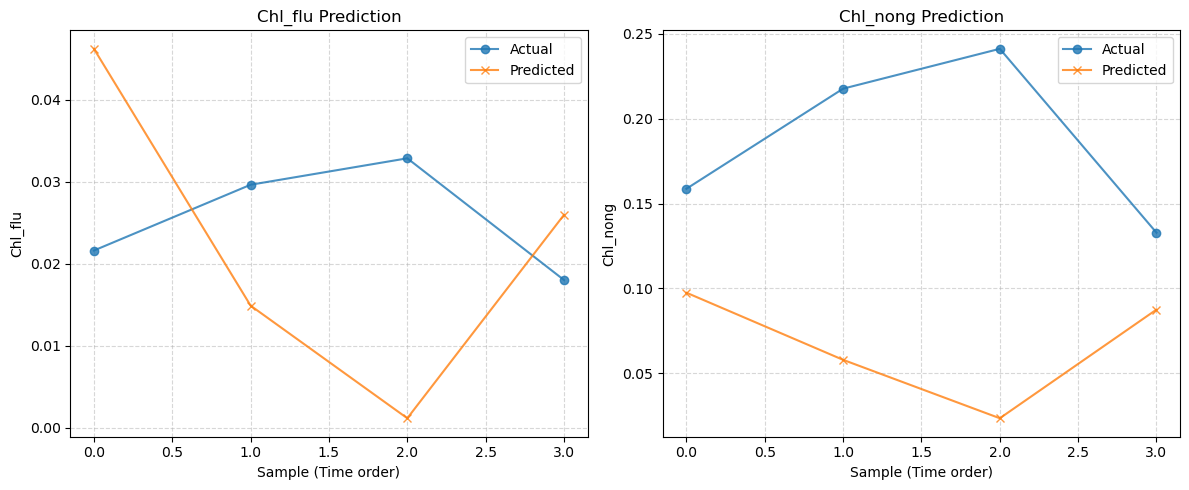

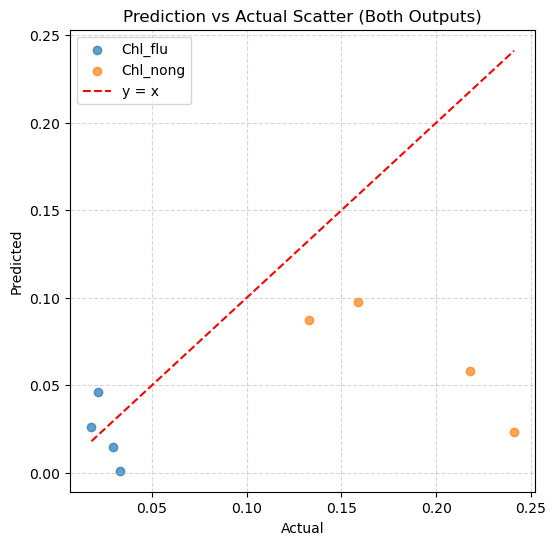

In [160]:
model.eval()
all_preds = []
all_labels = []
test_loss = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.float()
        y_test = y_test.float()

        y_preds = model(X_test)
        all_preds.append(y_preds.cpu())
        all_labels.append(y_test.cpu())
        test_loss += criterion(y_preds, y_test).item()

y_pred = torch.cat(all_preds, dim=0).numpy()
y_true = torch.cat(all_labels, dim=0).numpy()

mse_each = ((y_pred - y_true) ** 2).mean(axis=0)
print(f"MSE per feature → Chl_flu: {mse_each[0]:.6f}, Chl_nong: {mse_each[1]:.6f}")

print("\n=== 마지막 입력 및 예측 결과 ===")
print(f"입력 시퀀스 (마지막 샘플):\n{X_test[-1].numpy()}")
print(f"실제값 (y_true): {y_true[-1]}")
print(f"예측값 (y_pred): {y_pred[-1]}")

# Visualization
feature_names = ["Chl_flu", "Chl_nong"]
plt.figure(figsize=(12, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(y_true[:, i], label="Actual", marker='o', alpha=0.8)
    plt.plot(y_pred[:, i], label="Predicted", marker='x', alpha=0.8)
    plt.title(f"{feature_names[i]} Prediction")
    plt.xlabel("Sample (Time order)")
    plt.ylabel(feature_names[i])
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Scatter comparison
plt.figure(figsize=(6,6))
for i in range(2):
    plt.scatter(y_true[:, i], y_pred[:, i], label=feature_names[i], alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="y = x")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Prediction vs Actual Scatter (Both Outputs)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [161]:
feature_indices = [chl_flu_idx, chl_nong_idx]

# 마지막 샘플 실제값과 예측값 복원
dummy_true = np.zeros(scaled_features.shape[1])
dummy_pred = np.zeros(scaled_features.shape[1])

dummy_true[feature_indices] = y_true[-1]  # 스케일된 마지막 실제값
dummy_pred[feature_indices] = y_pred[-1]  # 스케일된 마지막 예측값

# 역변환
y_true_orig = scaler.inverse_transform(dummy_true.reshape(1, -1))[0, feature_indices]
y_pred_orig = scaler.inverse_transform(dummy_pred.reshape(1, -1))[0, feature_indices]
print("\n=== 마지막 입력 및 예측 결과 (원래 단위) ===")
print(f"실제값 (원래 단위): {y_true_orig}")
print(f"예측값 (원래 단위): {y_pred_orig}")


=== 마지막 입력 및 예측 결과 (원래 단위) ===
실제값 (원래 단위): [ 1.65031299 16.5698037 ]
예측값 (원래 단위): [ 2.36993412 10.98545324]


In [162]:
log_dict = {
    "datetime": time_str,
    "file_name": file_name,
    "best_epoch": best_epoch,
    "train_loss": best_train_loss,
    "val_loss": best_val_loss,
    "test_loss": test_loss,
    "hidden_size": hidden_size,
    "num_layers": num_layers
}
with open('weights/weights_result.csv', mode='a', newline='', encoding='utf-8') as f:
    df_new = pd.DataFrame([log_dict])
    df_new.to_csv('weights/weights_result.csv', mode='a', index=False, header=False, encoding='utf-8')